In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/RETINAL/

/content/drive/.shortcut-targets-by-id/19v_-z68QIom5bSkKsoiETI2xN8cPjPox/RETINAL


In [3]:
%ls

augment.ipynb  files/                 models/    test/      training.zip  unet_patches.ipynb
datasets/      fr-unet.ipynb          new_data/  test.zip   unet-2.ipynb
figs/          FR-Unet_patches.ipynb  outputs/   training/  unet.ipynb


In [4]:
# Libraries

import os
import time
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import cv2
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# UTILS

In [5]:
# Utils

def add_metric_history(metrics, hist):
    for k, _ in hist.items():
      hist[k].append(metrics[k])
    return hist


""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Data

In [6]:
# Data

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], 0)  # gray scale
        image = image/255.0 ## (512, 512)
        # image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = np.expand_dims(image, axis=0)  # (1, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = (mask > 0.5)*1 # binarize
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

# Loss

In [7]:
# Loss

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

# Metrics

In [8]:
import numpy as np
import torch
import cv2
from sklearn.metrics import roc_auc_score

def get_metrics(predict, target, threshold=None, predict_b=None):
    predict = torch.sigmoid(predict).cpu().detach().numpy().flatten()
    if predict_b is not None:
        predict_b = predict_b.flatten()
    else:
        predict_b = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy().flatten()
    else:
        target = target.flatten()
    tp = (predict_b * target).sum()
    tn = ((1 - predict_b) * (1 - target)).sum()
    fp = ((1 - target) * predict_b).sum()
    fn = ((1 - predict_b) * target).sum()
    auc = roc_auc_score(target>0.5, predict)
    acc = (tp + tn) / (tp + fp + fn + tn)
    pre = tp / (tp + fp)
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    iou = tp / (tp + fp + fn)
    f1 = 2 * pre * sen / (pre + sen)
    return {
        "AUC": np.round(auc, 4),
        "F1": np.round(f1, 4),
        "Acc": np.round(acc, 4),
        "Sen": np.round(sen, 4),
        "Spe": np.round(spe, 4),
        "Pre": np.round(pre, 4),
        "IOU": np.round(iou, 4),
    }


def count_connect_component(predict, target, threshold=None, connectivity=8):
    if threshold != None:
        predict = torch.sigmoid(predict).cpu().detach().numpy()
        predict = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy()
    pre_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        predict, dtype=np.uint8)*255, connectivity=connectivity)
    gt_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        target, dtype=np.uint8)*255, connectivity=connectivity)
    return pre_n/gt_n

# Unet

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [10]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.6 MB/s eta 0:00:00


In [11]:
from torch import nn
from timm.models.layers import trunc_normal_

class InitWeights_He(object):
    def __init__(self, neg_slope=1e-2):
        self.neg_slope = neg_slope

    def __call__(self, module):
        if isinstance(module, nn.Conv3d) or isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.ConvTranspose3d):
            module.weight = nn.init.kaiming_normal_(module.weight, a=self.neg_slope)
            if module.bias is not None:
                module.bias = nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            trunc_normal_(module.weight, std=self.neg_slope)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.bias, 0)
            nn.init.constant_(module.weight, 1.0)

In [12]:
class conv(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(conv, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True))


    def forward(self, x):
        return self.conv(x)


class feature_fuse(nn.Module):
    def __init__(self, in_c, out_c):
        super(feature_fuse, self).__init__()
        self.conv11 = nn.Conv2d(
            in_c, out_c, kernel_size=1, padding=0, bias=False)
        self.conv33 = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=1, bias=False)
        self.conv33_di = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=2, bias=False, dilation=2)
        self.norm = nn.BatchNorm2d(out_c)

    def forward(self, x):
        x1 = self.conv11(x)
        x2 = self.conv33(x)
        x3 = self.conv33_di(x)
        out = self.norm(x1+x2+x3)
        return out


class up(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(up, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2,
                               padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=False))

    def forward(self, x):
        x = self.up(x)
        return x


class down(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=2,
                      padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=True))

    def forward(self, x):
        x = self.down(x)
        return x


class block(nn.Module):
    def __init__(self, in_c, out_c,  dp=0, is_up=False, is_down=False, fuse=False):
        super(block, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        if fuse == True:
            self.fuse = feature_fuse(in_c, out_c)
        else:
            self.fuse = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1)

        self.is_up = is_up
        self.is_down = is_down
        self.conv = conv(out_c, out_c, dp=dp)
        if self.is_up == True:
            self.up = up(out_c, out_c//2)
        if self.is_down == True:
            self.down = down(out_c, out_c*2)

    def forward(self,  x):
        if self.in_c != self.out_c:
            x = self.fuse(x)
        x = self.conv(x)
        if self.is_up == False and self.is_down == False:
            return x
        elif self.is_up == True and self.is_down == False:
            x_up = self.up(x)
            return x, x_up
        elif self.is_up == False and self.is_down == True:
            x_down = self.down(x)
            return x, x_down
        else:
            x_up = self.up(x)
            x_down = self.down(x)
            return x, x_up, x_down


class FR_UNet(nn.Module):
    def __init__(self,  num_classes=1, num_channels=1, feature_scale=2,  dropout=0.2, fuse=True, out_ave=True):
        super(FR_UNet, self).__init__()
        self.out_ave = out_ave
        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / feature_scale) for x in filters]
        self.block1_3 = block(
            num_channels, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block1_2 = block(
            filters[0], filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block1_1 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block10 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block11 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block12 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=False, fuse=fuse)
        self.block13 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=False, fuse=fuse)
        self.block2_2 = block(
            filters[1], filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block2_1 = block(
            filters[1]*2, filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block20 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block21 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block22 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block3_1 = block(
            filters[2], filters[2],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block30 = block(
            filters[2]*2, filters[2],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block31 = block(
            filters[2]*3, filters[2],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block40 = block(filters[3], filters[3],
                             dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.final1 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final2 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final3 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final4 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final5 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.fuse = nn.Conv2d(
            5, num_classes, kernel_size=1, padding=0, bias=True)
        self.apply(InitWeights_He)

    def forward(self, x):
        x1_3, x_down1_3 = self.block1_3(x)
        x1_2, x_down1_2 = self.block1_2(x1_3)
        x2_2, x_up2_2, x_down2_2 = self.block2_2(x_down1_3)
        x1_1, x_down1_1 = self.block1_1(torch.cat([x1_2, x_up2_2], dim=1))
        x2_1, x_up2_1, x_down2_1 = self.block2_1(
            torch.cat([x_down1_2, x2_2], dim=1))
        x3_1, x_up3_1, x_down3_1 = self.block3_1(x_down2_2)
        x10, x_down10 = self.block10(torch.cat([x1_1, x_up2_1], dim=1))
        x20, x_up20, x_down20 = self.block20(
            torch.cat([x_down1_1, x2_1, x_up3_1], dim=1))
        x30, x_up30 = self.block30(torch.cat([x_down2_1, x3_1], dim=1))
        _, x_up40 = self.block40(x_down3_1)
        x11, x_down11 = self.block11(torch.cat([x10, x_up20], dim=1))
        x21, x_up21 = self.block21(torch.cat([x_down10, x20, x_up30], dim=1))
        _, x_up31 = self.block31(torch.cat([x_down20, x30, x_up40], dim=1))
        x12 = self.block12(torch.cat([x11, x_up21], dim=1))
        _, x_up22 = self.block22(torch.cat([x_down11, x21, x_up31], dim=1))
        x13 = self.block13(torch.cat([x12, x_up22], dim=1))
        if self.out_ave == True:
            output = (self.final1(x1_1)+self.final2(x10) +
                      self.final3(x11)+self.final4(x12)+self.final5(x13))/5
        else:
            output = self.final5(x13)

        return output

In [13]:
model = FR_UNet().to(0)


In [14]:
from torchsummary import summary
summary(model, (1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]              32
            Conv2d-2         [-1, 32, 128, 128]             288
            Conv2d-3         [-1, 32, 128, 128]             288
       BatchNorm2d-4         [-1, 32, 128, 128]              64
      feature_fuse-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 32, 128, 128]           9,216
       BatchNorm2d-7         [-1, 32, 128, 128]              64
         Dropout2d-8         [-1, 32, 128, 128]               0
         LeakyReLU-9         [-1, 32, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]           9,216
      BatchNorm2d-11         [-1, 32, 128, 128]              64
        Dropout2d-12         [-1, 32, 128, 128]               0
        LeakyReLU-13         [-1, 32, 128, 128]               0
             conv-14         [-1, 32, 1

In [15]:
# Read the data and set the parameters

In [16]:
""" Seeding """
seeding(42)

""" Load dataset """
train_x = sorted(glob("./datasets/DRIVE/patches/train/images/*"))
train_y = sorted(glob("./datasets/DRIVE/patches/train/masks/*"))

test_x = sorted(glob("./datasets/DRIVE/patches/test/images/*"))
test_y = sorted(glob("./datasets/DRIVE/patches/test/masks/*"))

In [17]:
""" Hyperparameters """
batch_size = 128
num_epochs = 200
lr = 1e-4
checkpoint_path = "models/unet-patches.pth"

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
test_dataset = DriveDataset(test_x, test_y)
validation_split = 0.5
test_size = int((1 - validation_split) * len(test_dataset))
valid_size = len(test_dataset) - test_size
# split dataset to train and valid
test_dataset, valid_dataset = random_split(test_dataset, [test_size, valid_size])


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


print(f"Dataset Size:\n  Train: {len(train_loader)}\n  Valid: {len(valid_loader)}\n  Test: {len(test_loader)}")

Dataset Size:
  Train: 3
  Valid: 2
  Test: 2


In [18]:
# model = model.to(0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=6, verbose=True)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.amp.GradScaler('cuda')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
create_dir("outputs/frunet-training/")

# load checkpoints

In [20]:
# sigm = nn.functional.sigmoid
def train(model, loader, optimizer, loss_fn, scale,  amp=True):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to("cuda")
        y = y.to("cuda")

        optimizer.zero_grad()

        if amp:
            with torch.amp.autocast('cuda'):  # Enable mixed precision
                outputs = model(x)
                loss = loss_fn(outputs, y)

            scaler.scale(loss).backward()  # Scale the loss and backpropagate
            scaler.step(optimizer)  # Step the optimizer
            scaler.update()  # Update the scaler
        else:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()


        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return x,y, outputs, epoch_loss

def evaluate(model, loader, loss_fn, amp=False):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to("cuda", torch.float16)
            y = y.to("cuda", torch.float16)
            if amp:
                with torch.amp.autocast('cuda'):  # Enable mixed precision
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

            else:
                outputs = model(x)
                loss = loss_fn(outputs, y)



            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader))
    return x,y, outputs, epoch_loss


In [21]:
torch.cuda.empty_cache()

In [22]:
num_epochs = 200

In [23]:
init_epoch = 1

In [24]:
""" Training the model """
best_valid_loss = float("inf")
history = {'epoch': [], 'train_loss': [], 'valid_loss': [], "time": []}
train_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
valid_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}

for epoch in range(init_epoch+1, num_epochs+1):
    start_time = time.time()

    x_tr, y_tr, outputs_tr, train_loss = train(model, train_loader, optimizer, loss_fn, scaler, True)
    x_val, y_val, outputs_val, valid_loss = evaluate(model, valid_loader, loss_fn, amp=True)
    # History
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['epoch'].append(epoch)
    ep_time = round(time.time()-start_time, 2)
    history['time'].append(ep_time)

    # metrics
    metric_train = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)
    metric_valid = get_metrics(predict=outputs_val, target=y_val, threshold=0.5)

    train_metric_hist = add_metric_history(metric_train, train_metric_hist)
    valid_metric_hist = add_metric_history(metric_valid, valid_metric_hist)

    print(f'Epoch [{epoch}/{num_epochs}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Time : {ep_time} s')

    # Save the model and images every 10 epochs
    if (epoch) % 10 == 0:
        state = {
        'history': history,
        'epoch' : epoch,
        'train_metric_history': train_metric_hist,
        'valid_metric_history': valid_metric_hist,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }
        torch.save(state, "models/frunet_last_epoch_patches.pth")

        # # Save 9 image results
        # folder_path = f'outputs/frunet-training/results/epoch{epoch}/'
        # create_dir(folder_path)
        # save_image(x_val.cpu(), folder_path+'images.png', nrow=2, normalize=True)
        # save_image(y_val.cpu(), folder_path+'original_masks.png', nrow=2, normalize=True)
        # save_image(outputs_val.cpu(), folder_path+'outputs.png', nrow=2, normalize=True)



    """ Saving the model """
    if valid_loss < best_valid_loss:
        data_str = "\033[33mValid loss improved\033[00m"
        print(data_str)

        best_valid_loss = valid_loss

        state = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }
        torch.save(state, f"models/frunet_best_patches.pth")


<ipython-input-8-b37f83a6f119>:22: RuntimeWarning: invalid value encountered in scalar divide
  pre = tp / (tp + fp)


Epoch [2/200] | Train Loss: 0.8530 | Valid Loss: 0.8541 | Time : 172.47 s
Valid loss improved
Epoch [3/200] | Train Loss: 0.8491 | Valid Loss: 0.8543 | Time : 13.22 s


<ipython-input-8-b37f83a6f119>:22: RuntimeWarning: invalid value encountered in scalar divide
  pre = tp / (tp + fp)


Epoch [4/200] | Train Loss: 0.8446 | Valid Loss: 0.8544 | Time : 13.3 s


<ipython-input-8-b37f83a6f119>:22: RuntimeWarning: invalid value encountered in scalar divide
  pre = tp / (tp + fp)


Epoch [5/200] | Train Loss: 0.8341 | Valid Loss: 0.8543 | Time : 13.5 s


<ipython-input-8-b37f83a6f119>:22: RuntimeWarning: invalid value encountered in scalar divide
  pre = tp / (tp + fp)
<ipython-input-8-b37f83a6f119>:22: RuntimeWarning: invalid value encountered in scalar divide
  pre = tp / (tp + fp)


Epoch [6/200] | Train Loss: 0.8271 | Valid Loss: 0.8535 | Time : 13.31 s
Valid loss improved


<ipython-input-8-b37f83a6f119>:22: RuntimeWarning: invalid value encountered in scalar divide
  pre = tp / (tp + fp)


Epoch [7/200] | Train Loss: 0.8209 | Valid Loss: 0.8512 | Time : 13.44 s
Valid loss improved


<ipython-input-8-b37f83a6f119>:22: RuntimeWarning: invalid value encountered in scalar divide
  pre = tp / (tp + fp)


Epoch [8/200] | Train Loss: 0.8105 | Valid Loss: 0.8456 | Time : 13.4 s
Valid loss improved
Epoch [9/200] | Train Loss: 0.8059 | Valid Loss: 0.8373 | Time : 13.38 s
Valid loss improved
Epoch [10/200] | Train Loss: 0.7927 | Valid Loss: 0.8297 | Time : 13.39 s
Valid loss improved
Epoch [11/200] | Train Loss: 0.7828 | Valid Loss: 0.8235 | Time : 13.8 s
Valid loss improved
Epoch [12/200] | Train Loss: 0.7698 | Valid Loss: 0.8122 | Time : 13.88 s
Valid loss improved
Epoch [13/200] | Train Loss: 0.7651 | Valid Loss: 0.7948 | Time : 13.6 s
Valid loss improved
Epoch [14/200] | Train Loss: 0.7536 | Valid Loss: 0.7740 | Time : 13.57 s
Valid loss improved
Epoch [15/200] | Train Loss: 0.7474 | Valid Loss: 0.7462 | Time : 13.54 s
Valid loss improved
Epoch [16/200] | Train Loss: 0.7452 | Valid Loss: 0.7205 | Time : 13.61 s
Valid loss improved
Epoch [17/200] | Train Loss: 0.7423 | Valid Loss: 0.7164 | Time : 13.71 s
Valid loss improved
Epoch [18/200] | Train Loss: 0.7273 | Valid Loss: 0.7086 | Time :

## test

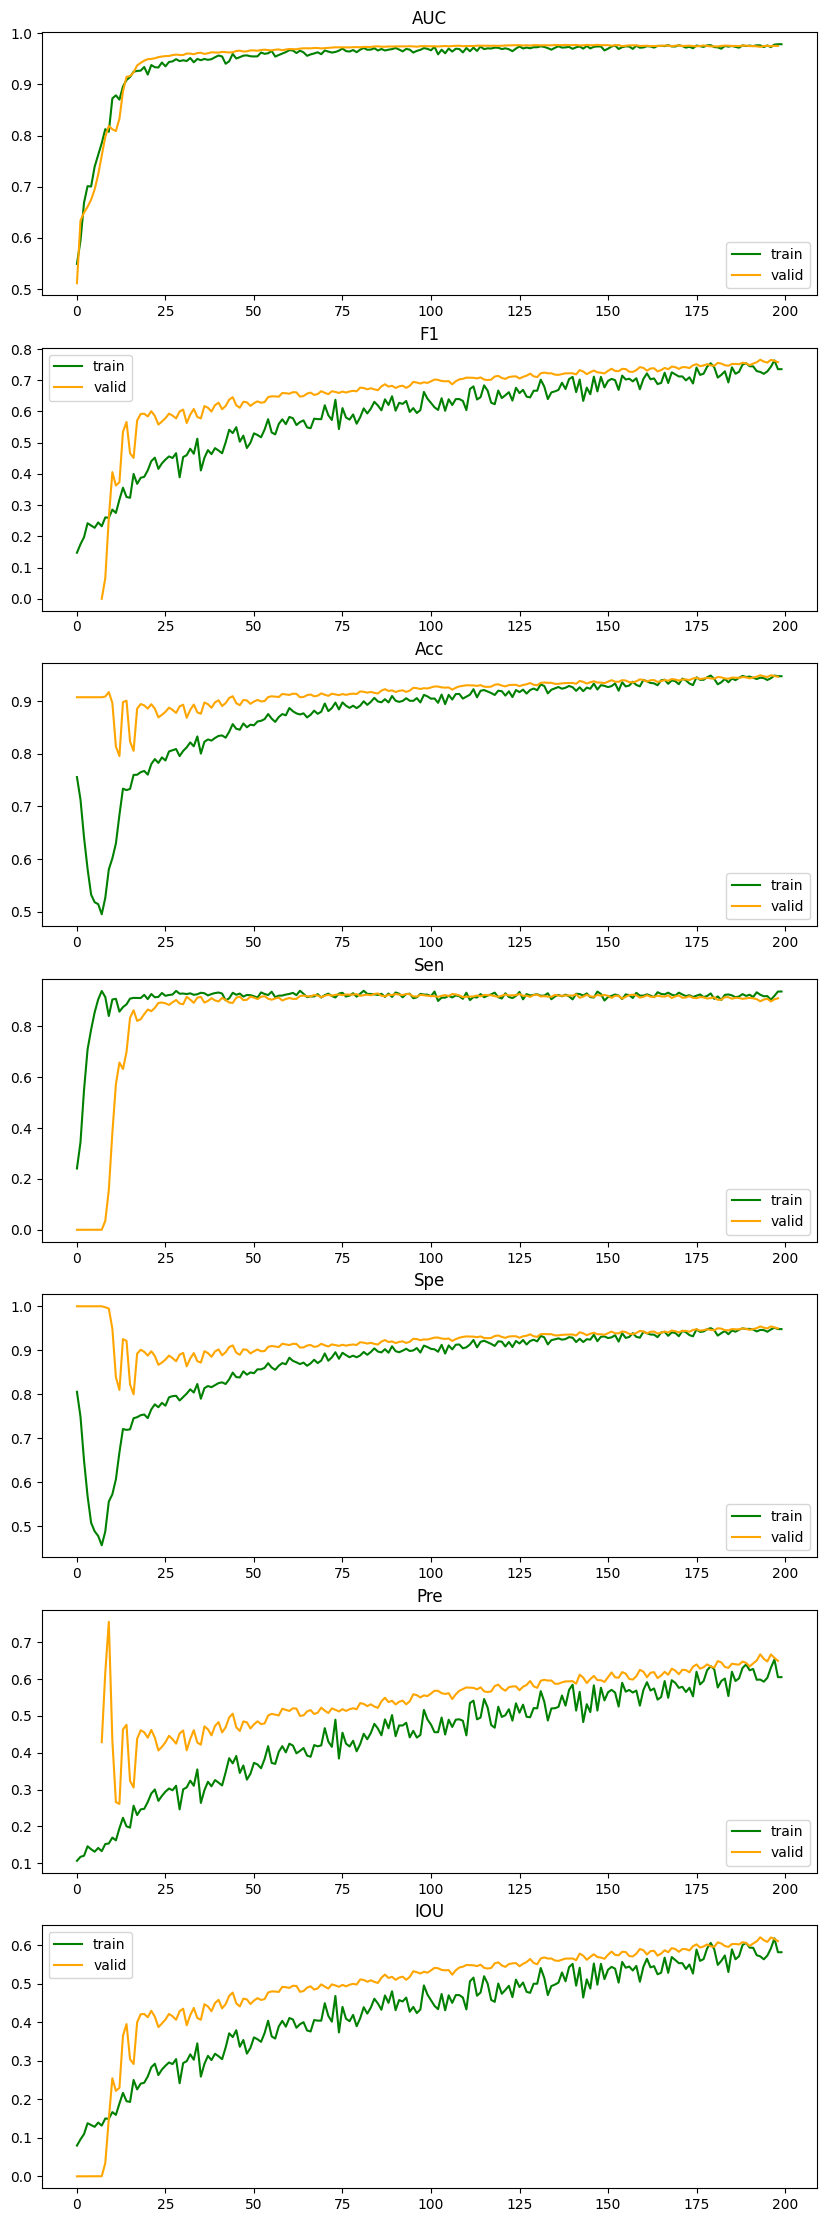

In [57]:
fig, axs = plt.subplots(7,1, figsize=(10,28))
for i, (k,v) in enumerate(train_metric_hist.items()):
  axs[i].plot(v, c='green', label='train');axs[i].set_title(k)
for i, (k,v) in enumerate(valid_metric_hist.items()):
  axs[i].plot(v, c='orange', label='valid')
  axs[i].legend()

In [28]:
create_dir("figs")
fig.savefig('figs/frunet-200-poch-patches.png')

In [31]:
x_test, y_test, outputs_val, test_loss = evaluate(model, test_loader, loss_fn, amp=True)

In [43]:
test_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
metric_test = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)
test_metric_hist = add_metric_history(metric_test, test_metric_hist)

In [44]:
test_loss

0.4753881096839905

In [47]:
test_metric_hist

{'AUC': [0.9784],
 'F1': [0.7354],
 'Acc': [0.9472],
 'Sen': [0.9367],
 'Spe': [0.9481],
 'Pre': [0.6052],
 'IOU': [0.5815]}

In [51]:
train_metric_hist["IOU"][-3]

0.6176